# Bridge Pledge

### Import supporting Libaries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  

# Adjust Variables

In [2]:
#add minimum attendance percentage as a DECIMAL  (anyone with an attendance percentage lower than this
#will not be graded)

att_pct=.2

#add raw point score boost for problem solvers caucus

ps_score=25

#Adjust weights for each Source
weights = {
    'A': 2, # Source_A: Authors of Bills with Cross Party Sponsors
    'B': 1, # Source_B: Ranked People who Cosponsor Bills
    'C': .5,# Source_C: Communication: Bipartisanship (Sum)
    'D': .5,# Source_D: Communication: Bipartisanship (Mean)
    'E': .5,# Source_E: Attack_Personal (Sum)
    'F': .5,# Source_F: Attack_Personal (Mean)
    'G': 0, # Source_G: Votes for Cosponsored Bill
    'H': 0, # Source_H: Votes for Bill Sponsored by Opposing Party
    
#The following weights are multiplied against a norm value of 100 so set the number based on that percentage
#if you want 10% set this value to .001
    'M':.001, #Source_M: PVI
    'N':.0005, # Source N: Vote view ideological score
    'O': 0 # Source O - APP Ideology Score
}

print(weights)


{'A': 2, 'B': 1, 'C': 0.5, 'D': 0.5, 'E': 0.5, 'F': 0.5, 'G': 0, 'H': 0, 'M': 0.001, 'N': 0.0005, 'O': 0}


# Data Sources:


In [3]:
#Links to All Source Files
#Congressional Data (List of all Congress people with bioguides, states, and districts)
meta_data=pd.read_csv('119th Congress.csv')

source_APP_profiles=pd.read_csv('2025-04-25 app raw profiles.csv')

#Source A: Cross Party CoSponsorship
source_A = pd.read_csv('ranked_cross_party_sponsorships.csv')

#Source B:  Cosponsors Cross Party Bills
source_B = pd.read_csv('ranked_cosponsors_cross_party_bills.csv')

#Source C/D/E/F: APP processed communications data 
source_APP = pd.read_csv('app_communications_2025_04_24.csv')

#Source G/H: Vote Data
source_vote=pd.read_csv('votes.csv')

#Source M House: Cook Political PVI
source_M_house=pd.read_csv('house_pvi.csv')

#Source M Senate: Cook Political PVI
source_M_senate=pd.read_csv('senate_pvi.csv')

#Source N: Vote View Ideological Scores
source_N =  pd.read_csv('HS119_members.csv')

#Source 0: APP Raw data
source_O=pd.read_csv('APP 2025-04-25.csv')


# Base Table

- Upload a CSV of the current members of Congress with bioguide ids, state, district, party, and chamber columns

In [4]:
#file_path='/content/drive/My Drive/Colab Notebooks/119th Congress.csv'
#meta_data=pd.read_csv(file_path)
meta_data.head()

,Name,Chamber,bioguide_id,State,District,Party
0,Barry Moore,House,M001212,Alabama,1,Republican
1,Shomari Figures,House,F000481,Alabama,2,Democratic
2,Mike D. Rogers,House,R000575,Alabama,3,Republican
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican
4,Dale W. Strong,House,S001220,Alabama,5,Republican


In [5]:
#create df of only house members
house_final=meta_data[meta_data["Chamber"]=="House"]
house_final.head()

,Name,Chamber,bioguide_id,State,District,Party
0,Barry Moore,House,M001212,Alabama,1,Republican
1,Shomari Figures,House,F000481,Alabama,2,Democratic
2,Mike D. Rogers,House,R000575,Alabama,3,Republican
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican
4,Dale W. Strong,House,S001220,Alabama,5,Republican


In [6]:
#create df of only senate members
senate_final=meta_data[meta_data["Chamber"]=="Senate"]
senate_final.head()

,Name,Chamber,bioguide_id,State,District,Party
7,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican
8,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican
10,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican
11,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican
21,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic


# Remove members below attendance threshold

In [7]:
#useing source_APP_profiles create a dataframe with names, bioguide ides and attendances

source_att=source_APP_profiles[['full_name','bioguide_id','attendance_total', 'attendance_max']]
#fill NAs with 0
source_att['attendance_total']=source_att['attendance_total'].fillna(0)

#create attendance percentage
source_att['attendance_pct']=source_att['attendance_total']/ source_att['attendance_max']

#create dataframe of members with percentage below mark set above
source_att_low=source_att[source_att['attendance_pct']<att_pct]

#drop duplicate rows
source_att_low=source_att_low.drop_duplicates()

#print dataframe of low atteandance members
source_att_low

,full_name,bioguide_id,attendance_total,attendance_max,attendance_pct
96,Eleanor Norton,N000147,2.0,72,0.027778
208,Stacey Plaskett,P000610,0.0,72,0.000000
211,Aumua Amata Radewagen,R000600,0.0,72,0.000000
407,James (Jim) Moylan,M001219,0.0,72,0.000000
502,Kimberlyn King-Hinds,K000404,0.0,72,0.000000
522,Pablo José Hernández Rivera,H001103,0.0,72,0.000000
537,Jimmy Patronis,P000622,0.0,72,0.000000
538,Randall Fine,F000484,0.0,72,0.000000


In [8]:
#create list of bioguide_ids to delete
bioguide_id_delete = source_att_low['bioguide_id'].tolist()

#delete bioguide_ids from grades of members with low attendance
house_final = house_final[~house_final['bioguide_id'].isin(bioguide_id_delete)]
senate_final = senate_final[~senate_final['bioguide_id'].isin(bioguide_id_delete)]


# Source Data


# Source_A: Authors of Bills with Cross Party Sponsors

Rewards authors of bills with cross party sponsors. This counts the total number of bills each representative has that have cross-party sponsors. Representatives with the highest sum and rewarded more and have the highest rank. 

* Download data here for 119th Congress: https://open.pluralpolicy.com/data/session-csv/

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: bill_authors_cosponsors.ipynb

* NOTE: missing values should be filled with 0

In [9]:
# Load and filter the source file
#source_A = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ranked_cross_party_sponsorships.csv')
source_A = source_A[['primary_bioguide_id', 'num_bills_with_cross_party_cosponsors']]
source_A.head(3)

,primary_bioguide_id,num_bills_with_cross_party_cosponsors
0,K000367,28
1,B001243,26
2,F000466,25


In [10]:
#HOUSE
house_final = pd.merge(house_final, source_A, left_on='bioguide_id', right_on='primary_bioguide_id', how='left')

# Fill missing values with 0 
house_final['num_bills_with_cross_party_cosponsors'] = house_final['num_bills_with_cross_party_cosponsors'].fillna(0)

# Recalculate mean and std
mean_A = house_final['num_bills_with_cross_party_cosponsors'].mean()
std_A = house_final['num_bills_with_cross_party_cosponsors'].std()

# Add normalized column
house_final['norm_A'] = norm.cdf(house_final['num_bills_with_cross_party_cosponsors'], mean_A, std_A) * 100
house_final['norm_A'] = house_final['norm_A'].round(2)

#rename column to include source A
house_final = house_final.rename(columns={'num_bills_with_cross_party_cosponsors': 'A: num_bills_with_cross_party_cosponsors'})
house_final.drop('primary_bioguide_id', axis=1, inplace=True)

house_final.head()

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62


In [11]:
#SENATE
senate_final = pd.merge(senate_final, source_A, left_on='bioguide_id', right_on='primary_bioguide_id', how='left')

# Fill missing values with 0
senate_final['num_bills_with_cross_party_cosponsors'] = senate_final['num_bills_with_cross_party_cosponsors'].fillna(0)

# Recalculate mean and std
mean_A = senate_final['num_bills_with_cross_party_cosponsors'].mean()
std_A = senate_final['num_bills_with_cross_party_cosponsors'].std()

# Add normalized column
senate_final['norm_A'] = norm.cdf(senate_final['num_bills_with_cross_party_cosponsors'], mean_A, std_A) * 100
senate_final['norm_A'] = senate_final['norm_A'].round(2)

senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'num_bills_with_cross_party_cosponsors': 'A: num_bills_with_cross_party_cosponsors'})
senate_final.drop('primary_bioguide_id', axis=1, inplace=True)
senate_final.head()

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12


# Source_B: Ranked People who Cosponsor Bills

* Download data here for 119th Congress: https://open.pluralpolicy.com/data/session-csv/

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: bill_authors_cosponsors.ipynb

* NOTE: missing values should be filled with 0

In [12]:
#Load and Filter the Source File
#source_B = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ranked_cosponsors_cross_party_bills.csv')
source_B = source_B[['bioguide_id', 'num_cross_party_cosponsored_bills']]


In [13]:
#HOUSE
house_final = pd.merge(house_final, source_B, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values with zero
house_final['num_cross_party_cosponsored_bills'] = house_final['num_cross_party_cosponsored_bills'].fillna(0)

# Recalculate mean and std
mean_B = house_final['num_cross_party_cosponsored_bills'].mean()
std_B = house_final['num_cross_party_cosponsored_bills'].std()

# Add normalized column
house_final['norm_B'] = norm.cdf(house_final['num_cross_party_cosponsored_bills'], mean_B, std_B) * 100
house_final['norm_B'] = house_final['norm_B'].round(2)
house_final = house_final.rename(columns={'num_cross_party_cosponsored_bills': 'B: num_cross_party_cosponsored_bills'})
house_final.head()


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95


In [14]:
#SENATE
senate_final = pd.merge(senate_final, source_B, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values with zero
senate_final['num_cross_party_cosponsored_bills'] = senate_final['num_cross_party_cosponsored_bills'].fillna(0)

# Recalculate mean and std
mean_B = senate_final['num_cross_party_cosponsored_bills'].mean()
std_B = senate_final['num_cross_party_cosponsored_bills'].std()

# Add normalized column
senate_final['norm_B'] = norm.cdf(senate_final['num_cross_party_cosponsored_bills'], mean_B, std_B) * 100
senate_final['norm_B'] = senate_final['norm_B'].round(2)
senate_final = senate_final.rename(columns={'num_cross_party_cosponsored_bills': 'B: num_cross_party_cosponsored_bills'})
senate_final.head()


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42


# Source_C: Communication: Bipartisanship (Sum)

Rewards representatives who participate in bipartisanship communication. This counts the total number of communications for each representative that are supportive of another representative of the opposite party. Those with a higher sum are rewarded more. 

* Download data: https://americaspoliticalpulse.com/data/ - select US officials in left menu; then select "Download 2025"

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: app_rhetoric_calculations.ipynb


In [15]:
# Load and filter the source file
#source_C = pd.read_csv('/content/drive/My Drive/Colab Notebooks/app_communications_2025_jc.csv')
source_C = source_APP[['bioguide_id', 'outcome_bipartisanship']]

In [16]:
#HOUSE
house_final = pd.merge(house_final, source_C, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship' with 0
house_final['outcome_bipartisanship'] = house_final['outcome_bipartisanship'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_C = round(house_final['outcome_bipartisanship'].mean(), 2)
std_C = round(house_final['outcome_bipartisanship'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
house_final['norm_C'] = norm.cdf(house_final['outcome_bipartisanship'], mean_C, std_C) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'outcome_bipartisanship': 'C: outcome_bipartisanship'})

# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,2.0,16.907135
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,6.0,21.499539
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,4.0,19.118864
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,9.0,25.375115
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,20.0,42.113599


In [17]:
#SENATE
senate_final = pd.merge(senate_final, source_C, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship' with 0
senate_final['outcome_bipartisanship'] = senate_final['outcome_bipartisanship'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_C = round(senate_final['outcome_bipartisanship'].mean(), 2)
std_C = round(senate_final['outcome_bipartisanship'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
senate_final['norm_C'] = norm.cdf(senate_final['outcome_bipartisanship'], mean_C, std_C) * 100


# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'outcome_bipartisanship': 'C: outcome_bipartisanship'})

# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,195.0,99.071522
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,64.0,49.168328
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,22.0,21.702803
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,42.0,33.735663
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,25.0,23.334275


# Source_D: Communication: Bipartisanship (Mean)

Rewards representatives who participate in bipartisanship communication. This measures the percent of communication that is supportive of a bipartisan representative. Those with a higher percentage of bipartisan communication are rewarded more.

* Download data: https://americaspoliticalpulse.com/data/ - select US officials in left menu; then select "Download 2025"

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: app_rhetoric_calculations.ipynb


In [18]:
# Load and filter the source file
#source_D = pd.read_csv('/content/drive/My Drive/Colab Notebooks/app_communications_2025_jc.csv')
source_D = source_APP[['bioguide_id', 'outcome_bipartisanship_pct']]

In [19]:
#HOUSE
house_final = pd.merge(house_final, source_D, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with zero
house_final['outcome_bipartisanship_pct'] = house_final['outcome_bipartisanship_pct'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_D = round(house_final['outcome_bipartisanship_pct'].mean(), 2)
std_D = round(house_final['outcome_bipartisanship_pct'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
house_final['norm_D'] = norm.cdf(house_final['outcome_bipartisanship_pct'], mean_D, std_D) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'outcome_bipartisanship_pct': 'D: outcome_bipartisanship_pct'})
# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,2.0,16.907135,0.921659,11.212972
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,6.0,21.499539,3.896104,31.339530
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,4.0,19.118864,2.985075,23.899455
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,9.0,25.375115,5.660377,47.853567
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,20.0,42.113599,9.900990,83.781977


In [20]:
#SENATE
senate_final = pd.merge(senate_final, source_D, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with zero
senate_final['outcome_bipartisanship_pct'] = senate_final['outcome_bipartisanship_pct'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_D = round(senate_final['outcome_bipartisanship_pct'].mean(), 2)
std_D = round(senate_final['outcome_bipartisanship_pct'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
senate_final['norm_D'] = norm.cdf(senate_final['outcome_bipartisanship_pct'], mean_D, std_D) * 100


# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'outcome_bipartisanship_pct': 'D: outcome_bipartisanship_pct'})
# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,195.0,99.071522,14.896868,94.641353
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,64.0,49.168328,4.155844,20.794303
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,22.0,21.702803,5.655527,31.737555
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,42.0,33.735663,4.615385,23.889999
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,25.0,23.334275,6.281407,36.927725


# Source_E: Attack_Personal (Sum)

Punishes any communication that is a personal attack. This specifically measures the total number of personal attacks. Those with a large sum will be rewarded less and thus ranked lower. 

* Download data: https://americaspoliticalpulse.com/data/ - select US officials in left menu; then select "Download 2025"

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: app_rhetoric_calculations.ipynb

In [21]:
# Load and filter the source file
source_E = source_APP[['bioguide_id', 'attack_personal']]


In [22]:
#HOUSE
house_final = pd.merge(house_final, source_E, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'attack_personal' with zero
house_final['attack_personal'] = house_final['attack_personal'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_E = round(house_final['attack_personal'].mean(), 2)
std_E = round(house_final['attack_personal'].std(), 2)

# Normalize the 'attack_personal' column; inverse (the more attacks the lower score)
house_final['norm_E'] = (1-norm.cdf(house_final['attack_personal'], mean_E, std_E)) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'attack_personal': 'E: attack_personal'})

# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,2.0,16.907135,0.921659,11.212972,4.0,66.930387
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,6.0,21.499539,3.896104,31.339530,1.0,70.897521
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,4.0,19.118864,2.985075,23.899455,2.0,69.599852
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,9.0,25.375115,5.660377,47.853567,2.0,69.599852
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,20.0,42.113599,9.900990,83.781977,1.0,70.897521


In [23]:
#SENATE
senate_final = pd.merge(senate_final, source_E, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'attack_personal' with the column mean
mean_E= round(senate_final['attack_personal'].mean(), 2)
senate_final['attack_personal'] = senate_final['attack_personal'].fillna(mean_D)

# Calculate mean and standard deviation for normalization
mean_E = round(senate_final['attack_personal'].mean(), 2)
std_E = round(senate_final['attack_personal'].std(), 2)

# Normalize the 'attack_personal' column; inverse (the more attacks the lower score)
senate_final['norm_E'] = (1-norm.cdf(senate_final['attack_personal'], mean_E, std_E)) * 100


# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'attack_personal': 'E: attack_personal'})
# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,195.0,99.071522,14.896868,94.641353,6.0,72.608868
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,64.0,49.168328,4.155844,20.794303,37.0,57.661395
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,22.0,21.702803,5.655527,31.737555,3.0,73.907274
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,42.0,33.735663,4.615385,23.889999,29.0,61.732932
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,25.0,23.334275,6.281407,36.927725,28.0,62.233857


# Source_F: Attack_Personal (Mean)

Punishes any communication that is a personal attack. This measures the percent of communication that is in the form of a personal attack for each representative.  Those with a larger percentage will be rewarded less and thus ranked lower. 

* Download data: https://americaspoliticalpulse.com/data/ - select US officials in left menu; then select "Download 2025"

* Date downloaded: April 24, 2025

* Jupyter Notebook Used to Obtain Data: app_rhetoric_calculations.ipynb

In [24]:
# Load and filter the source file
source_F = source_APP[['bioguide_id', 'attack_personal_pct']]


In [25]:
#HOUSE
house_final = pd.merge(house_final, source_F, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'attack_personal_pct' with the column mean
mean_F= round(house_final['attack_personal_pct'].mean(), 2)
house_final['attack_personal_pct'] = house_final['attack_personal_pct'].fillna(mean_F)

# Calculate mean and standard deviation for normalization
mean_F = round(house_final['attack_personal_pct'].mean(), 2)
std_F = round(house_final['attack_personal_pct'].std(), 2)

# Normalize the 'outcome_bipartisanship' column; inverse the number (more attacks = lower score)
house_final['norm_F'] = (1-norm.cdf(house_final['attack_personal_pct'], mean_F, std_F)) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'attack_personal_pct': 'F: attack_personal_pct'})

# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,2.0,16.907135,0.921659,11.212972,4.0,66.930387,1.843318,63.634059
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,6.0,21.499539,3.896104,31.339530,1.0,70.897521,0.649351,74.929176
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,4.0,19.118864,2.985075,23.899455,2.0,69.599852,1.492537,67.139080
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,9.0,25.375115,5.660377,47.853567,2.0,69.599852,1.257862,69.404697
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,20.0,42.113599,9.900990,83.781977,1.0,70.897521,0.495050,76.241075


In [26]:
#SENATE
senate_final = pd.merge(senate_final, source_F, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'attack_personal_pct' with the column mean
mean_F= round(senate_final['attack_personal_pct'].mean(), 2)
senate_final['attack_personal_pct'] = senate_final['attack_personal_pct'].fillna(mean_F)

# Calculate mean and standard deviation for normalization
mean_F = round(senate_final['attack_personal_pct'].mean(), 2)
std_F = round(senate_final['attack_personal_pct'].std(), 2)

# Normalize the 'outcome_bipartisanship' column; inverse the number (more attacks = lower score)
senate_final['norm_F'] = (1-norm.cdf(senate_final['attack_personal_pct'], mean_F, std_F)) * 100


# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'attack_personal_pct': 'F: attack_personal_pct'})

# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,195.0,99.071522,14.896868,94.641353,6.0,72.608868,0.458365,79.696131
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,64.0,49.168328,4.155844,20.794303,37.0,57.661395,2.402597,67.891643
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,22.0,21.702803,5.655527,31.737555,3.0,73.907274,0.771208,77.991333
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,42.0,33.735663,4.615385,23.889999,29.0,61.732932,3.186813,62.437226
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,25.0,23.334275,6.281407,36.927725,28.0,62.233857,7.035176,34.172700


# Source_G: Votes for Cosponsored Bill

* Download data: https://open.pluralpolicy.com/data/session-csv/

* Date donwloaded: April 24, 2025

* Data cleaned in following file:  Vote_Counts.ipynb

* As of now this receives 0 weight because of low amount of data and concerns about bills that are making it to the floor only being those sponsored by Republicans.

In [27]:
#HOUSE

# Load and filter the source file
source_G = source_vote[['bioguide_id', 'Vote for Cosponsored Bill']]

house_final = pd.merge(house_final, source_G, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with the column mean
mean_G= round(house_final['Vote for Cosponsored Bill'].mean(), 2)
house_final['Vote for Cosponsored Bill'] = house_final['Vote for Cosponsored Bill'].fillna(mean_G)

# Calculate mean and standard deviation for normalization
mean_G = round(house_final['Vote for Cosponsored Bill'].mean(), 2)
std_G = round(house_final['Vote for Cosponsored Bill'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
house_final['norm_G'] = norm.cdf(house_final['Vote for Cosponsored Bill'], mean_G, std_G) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'Vote for Cosponsored Bill': 'G: Vote for Cosponsored Bill'})

# Output the preview the updated DataFrame
house_final.head(5)


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,2.0,16.907135,0.921659,11.212972,4.0,66.930387,1.843318,63.634059,7.0,82.186103
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,6.0,21.499539,3.896104,31.339530,1.0,70.897521,0.649351,74.929176,4.0,40.504494
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,4.0,19.118864,2.985075,23.899455,2.0,69.599852,1.492537,67.139080,7.0,82.186103
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,9.0,25.375115,5.660377,47.853567,2.0,69.599852,1.257862,69.404697,7.0,82.186103
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,20.0,42.113599,9.900990,83.781977,1.0,70.897521,0.495050,76.241075,7.0,82.186103


In [28]:
#SENATE

# Load and filter the source file
source_G = source_vote[['bioguide_id', 'Vote for Cosponsored Bill']]

senate_final = pd.merge(senate_final, source_G, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with the column mean
mean_G= round(senate_final['Vote for Cosponsored Bill'].mean(), 2)
senate_final['Vote for Cosponsored Bill'] = senate_final['Vote for Cosponsored Bill'].fillna(mean_G)

# Calculate mean and standard deviation for normalization
mean_G = round(senate_final['Vote for Cosponsored Bill'].mean(), 2)
std_G = round(senate_final['Vote for Cosponsored Bill'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
senate_final['norm_G'] = norm.cdf(senate_final['Vote for Cosponsored Bill'], mean_G, std_G) * 100

# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'Vote for Cosponsored Bill': 'G: Vote for Cosponsored Bill'})

# Output the preview the updated DataFrame
senate_final.head(5)


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,195.0,99.071522,14.896868,94.641353,6.0,72.608868,0.458365,79.696131,3.0,78.955497
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,64.0,49.168328,4.155844,20.794303,37.0,57.661395,2.402597,67.891643,3.0,78.955497
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,22.0,21.702803,5.655527,31.737555,3.0,73.907274,0.771208,77.991333,3.0,78.955497
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,42.0,33.735663,4.615385,23.889999,29.0,61.732932,3.186813,62.437226,3.0,78.955497
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,25.0,23.334275,6.281407,36.927725,28.0,62.233857,7.035176,34.172700,2.0,49.675660


# Source_H: Votes for Bill Sponsored by Opposing Party

* Download data: https://open.pluralpolicy.com/data/session-csv/

* Date donwloaded: April 24, 2025

* Data cleaned in following file:  Vote_Counts.ipynb

* As of now this receives 0 weight because of low amount of data and concerns about bills that are making it to the floor only being those sponsored by Republicans.

In [29]:
source_vote.head(2)

,Name,Chamber,bioguide_id,State,District,Party,Vote for Other Party,Vote for Cosponsored Bill
0,Barry Moore,House,M001212,Alabama,1,Republican,0.0,7.0
1,Shomari Figures,House,F000481,Alabama,2,Democratic,6.0,4.0


In [30]:
#HOUSE

# Load and filter the source file
source_H = source_vote[['bioguide_id', 'Vote for Other Party']]

house_final = pd.merge(house_final, source_H, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with the column mean
mean_H= round(house_final['Vote for Other Party'].mean(), 2)
house_final['Vote for Other Party'] = house_final['Vote for Other Party'].fillna(mean_H)

# Calculate mean and standard deviation for normalization
mean_H = round(house_final['Vote for Other Party'].mean(), 2)
std_H = round(house_final['Vote for Other Party'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
house_final['norm_H'] = norm.cdf(house_final['Vote for Other Party'], mean_H, std_H) * 100


# Remove duplicates based on 'bioguide_id'
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'Vote for Other Party': 'H: Vote for Other Party'})

# Output the preview the updated DataFrame
house_final.head(5)


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,0.921659,11.212972,4.0,66.930387,1.843318,63.634059,7.0,82.186103,0.0,26.259061
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,3.896104,31.339530,1.0,70.897521,0.649351,74.929176,4.0,40.504494,6.0,93.707648
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,2.985075,23.899455,2.0,69.599852,1.492537,67.139080,7.0,82.186103,0.0,26.259061
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,5.660377,47.853567,2.0,69.599852,1.257862,69.404697,7.0,82.186103,0.0,26.259061
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,9.900990,83.781977,1.0,70.897521,0.495050,76.241075,7.0,82.186103,0.0,26.259061


In [31]:
#SENATE

# Load and filter the source file
source_H = source_vote[['bioguide_id', 'Vote for Other Party']]

senate_final = pd.merge(senate_final, source_H, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'outcome_bipartisanship_pct' with the column mean
mean_H= round(senate_final['Vote for Other Party'].mean(), 2)
senate_final['Vote for Other Party'] = senate_final['Vote for Other Party'].fillna(mean_H)

# Calculate mean and standard deviation for normalization
mean_H = round(senate_final['Vote for Other Party'].mean(), 2)
std_H = round(senate_final['Vote for Other Party'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
senate_final['norm_H'] = norm.cdf(senate_final['Vote for Other Party'], mean_H, std_H) * 100


# Remove duplicates based on 'bioguide_id'
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'Vote for Other Party': 'H: Vote for Other Party'})

# Output the preview the updated DataFrame
senate_final.head(5)


,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,...,14.896868,94.641353,6.0,72.608868,0.458365,79.696131,3.0,78.955497,0.0,26.880262
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,...,4.155844,20.794303,37.0,57.661395,2.402597,67.891643,3.0,78.955497,0.0,26.880262
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,...,5.655527,31.737555,3.0,73.907274,0.771208,77.991333,3.0,78.955497,0.0,26.880262
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,...,4.615385,23.889999,29.0,61.732932,3.186813,62.437226,3.0,78.955497,0.0,26.880262
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,...,6.281407,36.927725,28.0,62.233857,7.035176,34.172700,2.0,49.675660,2.0,98.313512


# Source_M: Cook Political PVI

* This data was obtained by Brad via a paid subscription at: https://www.cookpolitical.com/cook-pvi

* Date downloaded: April 17, 2025

* Data cleaned in following file: PVI Pre-Processing.ipynb

In [32]:
#HOUSE

source_M_house=source_M_house[['bioguide_id', '2025 Cook PVI Number']]

# Merge the dataframes
house_final = pd.merge(house_final, source_M_house, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in '2023_pvi_raw' with 0
house_final['2025 Cook PVI Number'] = house_final['2025 Cook PVI Number'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_M = round(house_final['2025 Cook PVI Number'].mean(), 2)
std_M = round(house_final['2025 Cook PVI Number'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
house_final['norm_M'] = norm.cdf(house_final['2025 Cook PVI Number'], mean_M, std_M) * 100

house_final = house_final.rename(columns={'2025 Cook PVI Number': 'M: PVI'})
house_final['norm_M'] = np.where(house_final['M: PVI'] == 0, 0, house_final['norm_M'])
# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,4.0,66.930387,1.843318,63.634059,7.0,82.186103,0.0,26.259061,27,95.107163
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,1.0,70.897521,0.649351,74.929176,4.0,40.504494,6.0,93.707648,5,17.779565
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,2.0,69.599852,1.492537,67.139080,7.0,82.186103,0.0,26.259061,23,88.226800
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,2.0,69.599852,1.257862,69.404697,7.0,82.186103,0.0,26.259061,33,99.083130
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,1.0,70.897521,0.495050,76.241075,7.0,82.186103,0.0,26.259061,15,59.813959


In [33]:
#SENATE

source_M_senate=source_M_senate[['bioguide_id', '2025 Cook PVI Number']]

# Merge the dataframes
senate_final = pd.merge(senate_final, source_M_senate, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in '2023_pvi_raw' with 0
senate_final['2025 Cook PVI Number'] = senate_final['2025 Cook PVI Number'].fillna(0)

# Calculate mean and standard deviation for normalization
mean_M = round(senate_final['2025 Cook PVI Number'].mean(), 2)
std_M = round(senate_final['2025 Cook PVI Number'].std(), 2)

# Normalize the 'outcome_bipartisanship' column
senate_final['norm_M'] = norm.cdf(senate_final['2025 Cook PVI Number'], mean_M, std_M) * 100


senate_final = senate_final.rename(columns={'2025 Cook PVI Number': 'M: PVI'})
senate_final['norm_M'] = np.where(senate_final['M: PVI'] == 0, 0, senate_final['norm_M'])
# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,...,6.0,72.608868,0.458365,79.696131,3.0,78.955497,0.0,26.880262,14.81,85.084556
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,...,37.0,57.661395,2.402597,67.891643,3.0,78.955497,0.0,26.880262,14.81,85.084556
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,...,3.0,73.907274,0.771208,77.991333,3.0,78.955497,0.0,26.880262,6.46,36.169822
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,...,29.0,61.732932,3.186813,62.437226,3.0,78.955497,0.0,26.880262,6.46,36.169822
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,...,28.0,62.233857,7.035176,34.172700,2.0,49.675660,2.0,98.313512,0.00,0.000000


# Source N: Vote view ideological score

Add multiplier to scores based on distance from ideological center to reward bridging by non-centrist polls	

* Download data here: https://voteview.com/congress/senate/-1/text ; https://voteview.com/congress/house/-1/text

* Date downloaded: April 21, 2025

* Note this scoring is done with the absolute value of the downloaded data in order to measure how far each side is from the center.

In [34]:
# Filter columns to keep only 'bioguide_id' and 'nominate_dim1'
source_N = source_N[['bioguide_id', 'nominate_dim1']]
#take absolutely value of nominate_dim1
source_N['nominate_dim1']=np.abs(source_N['nominate_dim1'])
# Preview the filtered source DataFrame
source_N.head()


,bioguide_id,nominate_dim1
0,R000575,0.379
1,S001185,0.401
2,P000609,0.677
3,M001212,0.642
4,S001220,0.621


In [35]:
#HOUSE 
# Merge source_N with the final DataFrame on 'bioguide_id'
house_final = pd.merge(house_final, source_N, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim1' with the column mean
mean_N = round(source_N['nominate_dim1'].mean(), 2)
house_final['nominate_dim1'] = house_final['nominate_dim1'].fillna(mean_N)

# Calculate mean and standard deviation for normalization
mean_N = round(house_final['nominate_dim1'].mean(), 2)
std_N = round(house_final['nominate_dim1'].std(), 2)

# Normalize the 'nominate_dim1' column
house_final['norm_N'] = norm.cdf(house_final['nominate_dim1'], mean_N, std_N) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'nominate_dim1': 'N: nominate_dim1'})

# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M,N: nominate_dim1,norm_N
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,1.843318,63.634059,7.0,82.186103,0.0,26.259061,27,95.107163,0.642,85.782269
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,0.649351,74.929176,4.0,40.504494,6.0,93.707648,5,17.779565,0.375,30.853754
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,1.492537,67.139080,7.0,82.186103,0.0,26.259061,23,88.226800,0.379,31.686958
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,1.257862,69.404697,7.0,82.186103,0.0,26.259061,33,99.083130,0.405,37.314717
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,0.495050,76.241075,7.0,82.186103,0.0,26.259061,15,59.813959,0.621,82.819560


In [36]:
#SENATE 
# Merge source_N with the final DataFrame on 'bioguide_id'
senate_final = pd.merge(senate_final, source_N, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim1' with the column mean
mean_N = round(source_N['nominate_dim1'].mean(), 2)
senate_final['nominate_dim1'] = senate_final['nominate_dim1'].fillna(mean_N)

# Calculate mean and standard deviation for normalization
mean_N = round(senate_final['nominate_dim1'].mean(), 2)
std_N = round(senate_final['nominate_dim1'].std(), 2)

# Normalize the 'nominate_dim1' column
senate_final['norm_N'] = norm.cdf(senate_final['nominate_dim1'], mean_N, std_N) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)


senate_final = senate_final.rename(columns={'nominate_dim1': 'N: nominate_dim1'})

# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,F: attack_personal_pct,norm_F,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M,N: nominate_dim1,norm_N
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,...,0.458365,79.696131,3.0,78.955497,0.0,26.880262,14.81,85.084556,0.582,73.310212
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,...,2.402597,67.891643,3.0,78.955497,0.0,26.880262,14.81,85.084556,0.936,99.518569
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,...,0.771208,77.991333,3.0,78.955497,0.0,26.880262,6.46,36.169822,0.207,7.199248
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,...,3.186813,62.437226,3.0,78.955497,0.0,26.880262,6.46,36.169822,0.482,52.657646
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,...,7.035176,34.172700,2.0,49.675660,2.0,98.313512,0.00,0.000000,0.374,29.690143


# Source O - APP Ideology Score


* Download data: profiles.csv from americanpoliticalpulse.com/data

* Date downloaded: 04/24/2025

* Notes: Previously APP reported ideology_intensity; they have stopped reporting that number, but it is the absolute value of ideology_ideology so we are using that and converting it to the absolute value

In [37]:
# Filter columns to keep only 'bioguide_id' and 'nominate_dim1'
source_O = source_O[['bioguide_id', 'ideology_ideology']]
#use the absolute value of ideology_ideology
source_O['ideology_ideology']=np.abs(source_O['ideology_ideology'])
# Preview the filtered source DataFrame
source_O.head()


,bioguide_id,ideology_ideology
0,C000127,0.306
1,K000367,0.280
2,S000033,0.543
3,W000802,0.354
4,B001261,0.538


In [38]:
#HOUSE 
# Merge source_O with the final DataFrame on 'bioguide_id'
house_final = pd.merge(house_final, source_O, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim1' with the column mean
mean_O = round(source_O['ideology_ideology'].mean(), 2)
house_final['ideology_ideology'] = house_final['ideology_ideology'].fillna(mean_O)

# Calculate mean and standard deviation for normalization
mean_O = round(house_final['ideology_ideology'].mean(), 2)
std_O = round(house_final['ideology_ideology'].std(), 2)

# Normalize the 'nominate_dim1' column
house_final['norm_O'] = norm.cdf(house_final['ideology_ideology'], mean_O, std_O) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if house_final['bioguide_id'].duplicated().sum() > 0:
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final = house_final.rename(columns={'ideology_ideology': 'O: ideology_ideology'})

# Output the preview the updated DataFrame
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M,N: nominate_dim1,norm_N,O: ideology_ideology,norm_O
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,7.0,82.186103,0.0,26.259061,27,95.107163,0.642,85.782269,0.642,85.782269
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,4.0,40.504494,6.0,93.707648,5,17.779565,0.375,30.853754,0.375,30.853754
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,7.0,82.186103,0.0,26.259061,23,88.226800,0.379,31.686958,0.379,31.686958
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,7.0,82.186103,0.0,26.259061,33,99.083130,0.405,37.314717,0.405,37.314717
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,7.0,82.186103,0.0,26.259061,15,59.813959,0.621,82.819560,0.621,82.819560


In [39]:
#SENATE 
# Merge source_O with the final DataFrame on 'bioguide_id'
senate_final = pd.merge(senate_final, source_O, left_on='bioguide_id', right_on='bioguide_id', how='left')

# Fill missing values in 'nominate_dim1' with the column mean
mean_O = round(source_O['ideology_ideology'].mean(), 2)
senate_final['ideology_ideology'] = senate_final['ideology_ideology'].fillna(mean_O)

# Calculate mean and standard deviation for normalization
mean_O = round(senate_final['ideology_ideology'].mean(), 2)
std_O = round(senate_final['ideology_ideology'].std(), 2)

# Normalize the 'nominate_dim1' column
senate_final['norm_O'] = norm.cdf(senate_final['ideology_ideology'], mean_O, std_O) * 100

# Drop duplicates based on 'bioguide_id' if any exist
if senate_final['bioguide_id'].duplicated().sum() > 0:
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final = senate_final.rename(columns={'ideology_ideology': 'O: ideology_ideology'})

# Output the preview the updated DataFrame
senate_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,G: Vote for Cosponsored Bill,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M,N: nominate_dim1,norm_N,O: ideology_ideology,norm_O
0,Katie Boyd Britt,Senate,B001319,Alabama,NaN,Republican,0.0,13.72,0.0,7.84,...,3.0,78.955497,0.0,26.880262,14.81,85.084556,0.582,73.310212,0.582,73.310212
1,Tommy Tuberville,Senate,T000278,Alabama,NaN,Republican,2.0,22.12,10.0,20.08,...,3.0,78.955497,0.0,26.880262,14.81,85.084556,0.936,99.518569,0.936,99.518569
2,Lisa Murkowski,Senate,M001153,Alaska,NaN,Republican,16.0,93.40,31.0,64.56,...,3.0,78.955497,0.0,26.880262,6.46,36.169822,0.207,7.199248,0.207,7.199248
3,Dan Sullivan,Senate,S001198,Alaska,NaN,Republican,13.0,84.59,23.0,46.48,...,3.0,78.955497,0.0,26.880262,6.46,36.169822,0.482,52.657646,0.482,52.657646
4,Ruben Gallego,Senate,G000574,Arizona,NaN,Democratic,2.0,22.12,37.0,76.42,...,2.0,49.675660,2.0,98.313512,0.00,0.000000,0.374,29.690143,0.374,29.690143


## Source_P: Caucus Bump

In [40]:
problem_solvers = {
    'Name': [
        'Brian Fitzpatrick', 'Tom Suozzi', 'Josh Gottheimer', 'Ed Case',
        'Nicole Malliotakis', 'Andrew Garbarino', 'Don Bacon', 'Salud Carbajal',
        'Rob Bresnahan', 'Juan Ciscomani', 'Ben Cline', 'Jim Costa',
        'Angie Craig', 'Henry Cuellar', 'Don Davis', 'Debbie Dingell',
        'Chuck Edwards', 'Gabe Evans', 'Marie Gluesenkamp Perez', 'Jared Golden',
        'Josh Harder', 'Chrissy Houlahan', 'Steven Horsford', 'Greg Landsman',
        'Susie Lee', 'Donald Norcross', 'Jimmy Panetta', 'Chris Pappas',
        'Scott Peters', 'Brittany Pettersen', 'Brad Schneider', 'Hillary Scholten',
        'Darren Soto', 'Haley Stevens', 'Emilia Sykes', 'Dusty Johnson', 
        'David Joyce', 'Thomas Kean Jr.', 'Young Kim', 'Nick LaLota', 
        'Mike Lawler', 'Daniel Meuser', 'Blake Moore', 'James Moylan',
        'Maria Elvira Salazar', 'Bryan Steil', 'David Valadao'
    ],
    'bioguide_id': [
        'F000466', 'S001201', 'G000583', 'C001055',
        'M000317', 'G000597', 'B001298', 'C001112',
        'B001327', 'C001133', 'C001118', 'C001059',
        'C001119', 'C001063', 'D000230', 'D000624',
        'E000246', 'E000300', 'G000600', 'G000592',
        'H001090', 'H001085', 'H001066', 'L000601',
        'L000590', 'N000188', 'P000613', 'P000614',
        'P000608', 'P000620', 'S001190', 'S001221',
        'S001200', 'S001215', 'S001223', 'J000301',
        'J000295', 'K000398', 'K000397', 'L000598',
        'L000599', 'M001204', 'M001213', 'M001219',
        'S000168', 'S001213', 'V000129'
    ]
}

#convert to dataframe to add to meta_data
problem_solv_df=pd.DataFrame(problem_solvers)

house_final['score_P'] = house_final['bioguide_id'].isin(problem_solv_df['bioguide_id']).astype(int)

house_final['score_P'] = np.where(house_final['score_P'] == 1, ps_score, house_final['score_P'])
house_final.head(5)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,norm_G,H: Vote for Other Party,norm_H,M: PVI,norm_M,N: nominate_dim1,norm_N,O: ideology_ideology,norm_O,score_P
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,82.186103,0.0,26.259061,27,95.107163,0.642,85.782269,0.642,85.782269,0
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,40.504494,6.0,93.707648,5,17.779565,0.375,30.853754,0.375,30.853754,0
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,82.186103,0.0,26.259061,23,88.226800,0.379,31.686958,0.379,31.686958,0
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,82.186103,0.0,26.259061,33,99.083130,0.405,37.314717,0.405,37.314717,0
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,82.186103,0.0,26.259061,15,59.813959,0.621,82.819560,0.621,82.819560,0


### Score Calculation & Final Score

In [41]:
def cal_score(data, weights):
    # Copy the data to avoid modifying the original dataframe
    temp_data = data.copy()

    # Initialize columns
    temp_data['score_T'] = 0

    # Calculate 'score_T' by adding weighted norm values for each category
    for i in weights.keys():
        temp_data['score_T'] += temp_data[f"norm_{i}"] * weights[i]
        
    # Calculate scores for ideology multipliers BEFORE the caucus score
    temp_data['score_M'] = temp_data['score_T']*(temp_data['norm_M'] * weights['M'])
    temp_data['score_N'] = temp_data['score_T']*(temp_data['norm_N'] * weights['N'])
    
    #calculate score_U 
    if 'score_P' in temp_data.columns:
        temp_data['score_U'] = temp_data['score_P']+temp_data['score_T']+temp_data['score_M']+temp_data['score_N']
    else:
        temp_data['score_U'] =temp_data['score_T']+temp_data['score_M']+temp_data['score_N']
    
    
    # Calculate mean, std, and median of 'score_S'
    mean_U = round(temp_data['score_U'].mean(), 2)
    std_U = round(temp_data['score_U'].std(), 2)
    median_U = round(temp_data['score_U'].median(), 2)

    # Normalize 'score_S' using the cumulative distribution function (CDF)
    temp_data['norm_U'] = norm.cdf(temp_data['score_U'], mean_U, std_U) * 100

    # Define the grade assignment function based on the calculated scores
    def assign_grade(grade):
        if grade > mean_U + std_U:
            return 'A'
        elif grade > median_U:
            return 'B'
        elif grade > mean_U - std_U:
            return 'C'
        else:
            return 'F'

    # Apply the grade assignment to the 'score_S' column
    temp_data['Grade'] = temp_data['score_U'].apply(assign_grade)

    return temp_data



In [42]:
# HOUSE: Call the function to get the final scores and grades
house_scores = cal_score(house_final, weights)
# Display the specific columns
house_scores[['bioguide_id', 'Name', 'Party', 'score_U', 'Grade']].head()

,bioguide_id,Name,Party,score_U,Grade
0,M001212,Barry Moore,Republican,258.838026,B
1,F000481,Shomari Figures,Democratic,183.648405,C
2,R000575,Mike D. Rogers,Republican,211.454516,C
3,A000055,Robert B. Aderholt,Republican,215.158736,C
4,S001220,Dale W. Strong,Republican,264.082603,B


In [43]:
house_scores.head()

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,norm_N,O: ideology_ideology,norm_O,score_P,score_T,score_M,score_N,score_U,norm_U,Grade
0,Barry Moore,House,M001212,Alabama,1,Republican,4.0,60.01,3.0,27.95,...,85.782269,0.642,85.782269,0,227.450275,21.632150,9.755600,258.838026,50.245183,B
1,Shomari Figures,House,F000481,Alabama,2,Democratic,0.0,18.83,10.0,40.72,...,30.853754,0.375,30.853754,0,177.746090,3.160248,2.742067,183.648405,20.127641,C
2,Mike D. Rogers,House,R000575,Alabama,3,Republican,2.0,37.62,2.0,26.30,...,31.686958,0.379,31.686958,0,191.522696,16.897435,3.034386,211.454516,29.970883,C
3,Robert B. Aderholt,House,A000055,Alabama,4,Republican,1.0,27.43,5.0,31.40,...,37.314717,0.405,37.314717,0,192.494356,19.072943,3.591436,215.158736,31.430045,C
4,Dale W. Strong,House,S001220,Alabama,5,Republican,2.0,37.62,3.0,27.95,...,82.819560,0.621,82.819560,0,239.808310,14.343884,9.930409,264.082603,52.589761,B


In [44]:
house_scores[house_scores["Grade"]=="A"].sort_values(by="score_U", ascending=False).head(10)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,norm_N,O: ideology_ideology,norm_O,score_P,score_T,score_M,score_N,score_U,norm_U,Grade
39,Jimmy Panetta,House,P000613,California,19,Democratic,9.0,95.31,121.0,100.00,...,15.865525,0.290,15.865525,25,451.505113,32.771370,3.581683,512.858166,99.784723,A
322,Brian K. Fitzpatrick,House,F000466,Pennsylvania,1,Republican,25.0,100.00,247.0,100.00,...,2.949718,0.139,2.949718,25,473.243581,0.000000,0.697968,498.941548,99.652045,A
60,Young Kim,House,K000397,California,40,Republican,12.0,99.43,31.0,79.22,...,11.393143,0.255,11.393143,25,451.201918,3.693110,2.570304,482.465331,99.403185,A
271,Michael Lawler,House,L000599,New York,17,Republican,16.0,99.99,84.0,99.97,...,5.545484,0.189,5.545484,25,451.502377,0.000000,1.251900,477.754277,99.307614,A
265,Nicole Malliotakis,House,M000317,New York,11,Republican,20.0,100.00,27.0,73.05,...,23.830525,0.339,23.830525,25,430.967770,15.851870,5.135094,476.954734,99.290117,A
74,Joe Neguse,House,N000191,Colorado,2,Democratic,11.0,98.76,50.0,96.11,...,42.534610,0.428,42.534610,0,432.618762,34.525442,9.200635,476.344839,99.276509,A
244,Josh Gottheimer,House,G000583,New Jersey,5,Democratic,10.0,97.50,75.0,99.87,...,3.980605,0.162,3.980605,25,445.766939,4.505209,0.887211,476.159359,99.272325,A
413,Marie Gluesenkamp Perez,House,G000600,Washington,3,Democratic,10.0,97.50,42.0,91.36,...,1.432623,0.088,1.432623,25,449.662218,0.000000,0.322098,474.984317,99.245321,A
201,Debbie Dingell,House,D000624,Michigan,6,Democratic,7.0,86.58,46.0,94.10,...,36.427356,0.401,36.427356,25,418.449797,19.203326,7.621510,470.274633,99.128026,A
159,Zachary Nunn,House,N000193,Iowa,3,Republican,13.0,99.75,44.0,92.83,...,16.151871,0.292,16.151871,0,459.725341,4.646282,3.712712,468.084335,99.068231,A


In [45]:
# Senate: Call the function to get the final scores and grades
senate_scores = cal_score(senate_final, weights)
# Display the specific columns
senate_scores[['bioguide_id', 'Name', 'Party', 'score_U', 'Grade']].head(5)

,bioguide_id,Name,Party,score_U,Grade
0,B001319,Katie Boyd Britt,Republican,233.782522,C
1,T000278,Tommy Tuberville,Republican,184.086059,C
2,M001153,Lisa Murkowski,Republican,368.150389,A
3,S001198,Dan Sullivan,Republican,325.783769,B
4,G000574,Ruben Gallego,Democratic,201.963428,C


In [46]:
senate_scores[senate_scores["Grade"]=="A"].sort_values(by="score_U", ascending=False).head(10)

,Name,Chamber,bioguide_id,State,District,Party,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,...,N: nominate_dim1,norm_N,O: ideology_ideology,norm_O,score_T,score_M,score_N,score_U,norm_U,Grade
44,Amy Klobuchar,Senate,K000367,Minnesota,NaN,Democratic,28.0,99.97,81.0,99.94,...,0.280,14.558566,0.280,14.558566,456.812294,7.137402,3.325266,467.274962,98.888469,A
29,Chuck Grassley,Senate,G000386,Iowa,NaN,Republican,21.0,98.98,30.0,62.39,...,0.361,27.240496,0.361,27.240496,418.977552,14.195688,5.706578,438.879819,97.563850,A
54,Catherine Cortez Masto,Senate,C001113,Nevada,NaN,Democratic,20.0,98.45,55.0,96.07,...,0.353,25.784611,0.353,25.784611,425.937693,0.000000,5.491319,431.429012,97.050370,A
34,Bill Cassidy,Senate,C001075,Louisiana,NaN,Republican,23.0,99.59,33.0,68.76,...,0.464,48.670439,0.464,48.670439,395.488385,25.367615,9.624297,430.480297,96.978963,A
42,Gary C. Peters,Senate,P000595,Michigan,NaN,Democratic,22.0,99.35,65.0,99.03,...,0.246,10.666802,0.246,10.666802,415.359872,0.000000,2.215281,417.575153,95.857360,A
31,Jerry Moran,Senate,M000934,Kansas,NaN,Republican,14.0,88.13,23.0,46.48,...,0.414,37.785808,0.414,37.785808,388.355310,17.997187,7.337160,413.689656,95.460167,A
84,John Cornyn,Senate,C001056,Texas,NaN,Republican,23.0,99.59,34.0,70.77,...,0.470,50.000000,0.470,50.000000,390.865584,12.839729,9.771640,413.476952,95.437568,A
8,Alex Padilla,Senate,P000145,California,NaN,Democratic,14.0,88.13,51.0,93.68,...,0.390,32.836064,0.390,32.836064,376.289951,25.897118,6.177941,408.365010,94.866733,A
57,Jeanne Shaheen,Senate,S001181,New Hampshire,NaN,Democratic,12.0,80.41,67.0,99.29,...,0.232,9.304708,0.232,9.304708,398.445947,5.404110,1.853712,405.703769,94.547831,A
15,Christopher A. Coons,Senate,C001088,Delaware,NaN,Democratic,15.0,91.05,68.0,99.40,...,0.236,9.680048,0.236,9.680048,380.482069,17.581864,1.841542,399.905476,93.798837,A


In [47]:
#reorder house_scores so score_P is after score_T as it is not included in score_T
house_scores=house_scores[['Name', 'Chamber', 'bioguide_id', 'State', 'District', 'Party',
       'A: num_bills_with_cross_party_cosponsors', 'norm_A',
       'B: num_cross_party_cosponsored_bills', 'norm_B',
       'C: outcome_bipartisanship', 'norm_C', 'D: outcome_bipartisanship_pct',
       'norm_D', 'E: attack_personal', 'norm_E', 'F: attack_personal_pct',
       'norm_F', 'G: Vote for Cosponsored Bill', 'norm_G',
       'H: Vote for Other Party', 'norm_H', 'M: PVI', 'norm_M',
       'N: nominate_dim1', 'norm_N', 'O: ideology_ideology', 'norm_O',
        'score_T','score_P', 'score_M', 'score_N', 'score_U', 'norm_U',
       'Grade']]

In [48]:
#convert numeric columns to numeric for purposes of export

sen_columns=['A: num_bills_with_cross_party_cosponsors', 'norm_A',
       'B: num_cross_party_cosponsored_bills', 'norm_B',
       'C: outcome_bipartisanship', 'norm_C', 'D: outcome_bipartisanship_pct',
       'norm_D', 'E: attack_personal', 'norm_E', 'F: attack_personal_pct',
       'norm_F', 'G: Vote for Cosponsored Bill', 'norm_G',
       'H: Vote for Other Party', 'norm_H', 'M: PVI',
       'N: nominate_dim1', 'norm_N', 'score_T', 'score_M', 'score_N', 'score_U', 'norm_U']
for col in sen_columns:
    senate_scores[col] = pd.to_numeric(senate_scores[col], errors='coerce')

house_columns=['A: num_bills_with_cross_party_cosponsors', 'norm_A',
       'B: num_cross_party_cosponsored_bills', 'norm_B',
       'C: outcome_bipartisanship', 'norm_C', 'D: outcome_bipartisanship_pct',
       'norm_D', 'E: attack_personal', 'norm_E', 'F: attack_personal_pct',
       'norm_F', 'G: Vote for Cosponsored Bill', 'norm_G',
       'H: Vote for Other Party', 'norm_H', 'M: PVI', 'N: nominate_dim1', 
        'norm_N', 'score_T','score_P', 'score_M', 'score_N','score_U',  'norm_U']
for col in house_columns:
    house_scores[col] = pd.to_numeric(house_scores[col], errors='coerce')

In [49]:
#export scores as excel
senate_scores.to_excel('senate_scores_119.xlsx', sheet_name='119 Grades', index=True, header=True)
house_scores.to_excel('house_scores_119.xlsx', sheet_name='119 Grades', index=True, header=True)

In [50]:
# Senate: Call the function to get the final scores and grades
senate_final = cal_score(senate_final, weights) # Assign the result back to senate_final
# Display the specific columns
senate_final[['bioguide_id', 'Name', 'Party', 'score_U', 'Grade']].head(5)


,bioguide_id,Name,Party,score_U,Grade
0,B001319,Katie Boyd Britt,Republican,233.782522,C
1,T000278,Tommy Tuberville,Republican,184.086059,C
2,M001153,Lisa Murkowski,Republican,368.150389,A
3,S001198,Dan Sullivan,Republican,325.783769,B
4,G000574,Ruben Gallego,Democratic,201.963428,C


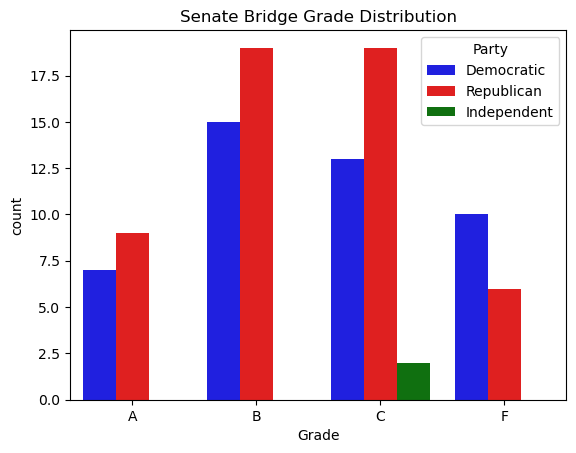

In [51]:
order=["A","B","C","F"]
hue_order=['Democratic','Republican','Independent']
# prompt: using senate_final plot "Grade" by "Party"

sns.countplot(x='Grade', hue='Party', data=senate_final,  palette=['b', 'r','g'],order=order, 
              hue_order=hue_order).set_title("Senate Bridge Grade Distribution")
plt.show()


In [52]:
# House: Call the function to get the final scores and grades
house_final = cal_score(house_final, weights) # Assign the result back to house_final
# Display the specific columns
house_final[['bioguide_id', 'Name', 'Party', 'score_U', 'Grade']].head(5)

,bioguide_id,Name,Party,score_U,Grade
0,M001212,Barry Moore,Republican,258.838026,B
1,F000481,Shomari Figures,Democratic,183.648405,C
2,R000575,Mike D. Rogers,Republican,211.454516,C
3,A000055,Robert B. Aderholt,Republican,215.158736,C
4,S001220,Dale W. Strong,Republican,264.082603,B


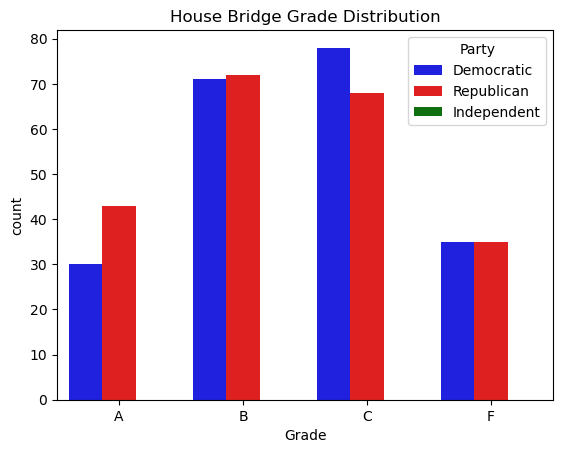

In [53]:
order=["A","B","C","F"]
hue_order=['Democratic','Republican','Independent']
# prompt: using senate_final plot "Grade" by "Party"

sns.countplot(x='Grade', hue='Party', data=house_final,  palette=['b', 'r','g'],
              order=order, hue_order=hue_order).set_title("House Bridge Grade Distribution")
plt.show()